In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from sklearn.model_selection import train_test_split
import helpers

sys.path.append(os.path.join('..'))
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *
from adp.optim import *


In [2]:
# Fetch/download data
D = helpers.fetch_german_data()
X, y, dtypes, feature_labels = D['X'], D['y'], D['dtypes'], D['feature_labels']

# Train models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
model_names = ['RandomForest-2']
model_dicts = helpers.create_and_train_models(
    model_names, dtypes, X_train, y_train, X_test=X_test, y_test=y_test)
random_forest_model = model_dicts[0]['model'] 

# Should be {'randomforestclassifier__max_depth': 6, 
#  'randomforestclassifier__n_estimators': 400}
print(model_dicts[0]['estimator'].best_params_)
# Should be 0.9142299850932755
print(random_forest_model(X[0, :]))

Loading fitted model from cache via file cached_model_7be1f53875b7a59dd77f0348e976751828c199de.pkl
{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 400}
0.9142299850932755


In [3]:
scale = np.ones(X.shape[1])
num_features = [i for i in range(len(dtypes)) if dtypes[i] == 'float64']
max_vals = np.max(X, axis=0)
min_vals = np.min(X, axis=0)
for i in num_features:
    scale[i] = 0.01 * (max_vals[i] - min_vals[i])

In [4]:
def compute_grad(x0, model, scale):
    # select numerical values
    num_features = [i for i in range(len(dtypes)) if dtypes[i] == 'float64']
    vv = np.zeros(x0.shape[0])
    vv[num_features] = 1
    pdiff = []
    for ii in range(x0.shape[0]):
        pdiff.append((model(x0 + vv * scale) - model(x0)) / scale[ii])
    return np.asarray(pdiff)

# Comparison to local model
def create_local_model(x0, model, scale):
    gradf = compute_grad(x0, model, scale)
    def local_model(X): # local model
        if np.asarray(X).ndim == 1:
            return model(x0) + np.dot(X - x0, gradf)
        return np.ones(X.shape[0]) * (model(x0) + np.dot(X - x0, gradf))
    return local_model

x0 = X[1, :]
# Could change to 3 if you want to see optimization over more than 1 coordinate
n_numeric_change = np.arange(1) + 1
utility = ModelContrastUtility(
    model=random_forest_model, other_model=create_local_model(x0, random_forest_model, scale)
)
best_curves= [
    optimize_curve(x0, utility, X, max_numeric_change=nc, dtypes=dtypes)
    for nc in n_numeric_change
]

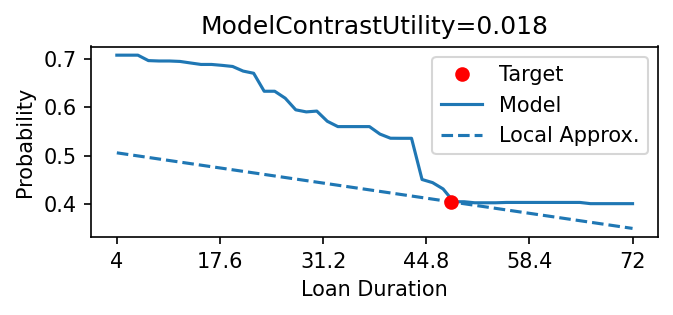

In [5]:
def plot_curves(best_curves, utility):
    n_change = len(best_curves)
    fig, axes = plt.subplots(n_change, 1, figsize=np.array([8, 4*n_change])*0.55, dpi=150, sharey=True)
    if n_change == 1:
        axes = np.array([axes])
    for c, ax in zip(best_curves, axes):
        plot_curve_vals(c, utility=utility, feature_labels=feature_labels,
                        other_model_label='Local Approx.', ax=ax)
    fig.tight_layout()
    
plot_curves(best_curves, utility)
ax = plt.gca()
ax.set_ylabel('Probability')
ax.set_xlabel('Loan Duration')

#plt.tight_layout()
plt.savefig('local2.pdf', bbox_inches='tight', pad_inches=0)